# Modelo lineal clasificador de imágenes de letras

In [1]:
import kagglehub
import torch
from pandas import read_csv,concat
import matplotlib.pyplot as plt
# import numpy as np

## Definición del modelo y de sus parámetros

In [2]:
# Import the Dataset from kaggle and load on a Tensor
Nist_dataset = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")

chunksize = 250

# the list that contains all the dataframes
list_of_dataframes = []

for df in read_csv(Nist_dataset+"/A_Z Handwritten Data.csv", chunksize=chunksize):
    # process your data frame here
    # then add the current data frame into the list
    list_of_dataframes.append(df)

# if you want all the dataframes together, here it is
handwritten_alphabet = concat(list_of_dataframes)



# handwritten_alphabet = read_csv(Nist_dataset+"/A_Z Handwritten Data.csv")
# print(handwritten_alphabet)
handwritten_alphabet = torch.Tensor(handwritten_alphabet.values).cuda()

In [3]:
from string import ascii_uppercase

# Crear una lista de letras del abecedario
letras = list(ascii_uppercase)  # Para mayúsculas, usa ascii_uppercase; para minúsculas, usa ascii_lowercase

# Crear el diccionario
alphabet_dictionary = {i: letras[i] for i in range(26)}

In [4]:
# Split The data on Images and Labels
# handwritten_alphabet[:,0]
handwritten_alphabet_classes = handwritten_alphabet[:,0].long()
handwritten_alphabet_images = handwritten_alphabet[:,1:].reshape((-1,28,28))

In [5]:
#Create a Dataset Class to load the Images and labels
class image_dataset(torch.utils.data.Dataset):
    def __init__(self,images:torch.Tensor,labels:torch.Tensor):
        if len(images[:]) != len(labels):
            raise IndexError("The size must be the same")
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        image = self.images[None,index]
        label = self.labels[None,index]
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [6]:
# Create and Split the dataset on Train, Validation and Test Datasets
image_dataset = image_dataset(handwritten_alphabet_images,handwritten_alphabet_classes)

train,val,test = torch.utils.data.random_split(image_dataset,[0.8,0.1,0.1])


R


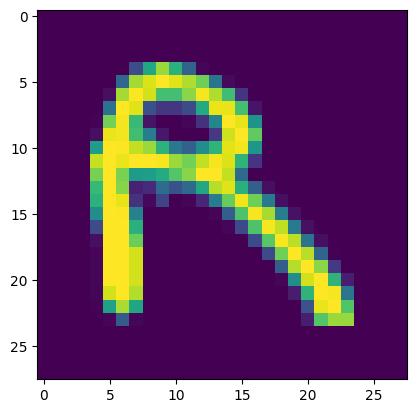

In [7]:
# # Show a data example
img,lbl = train[torch.randint(len(train),size=(1,))]
plt.imshow(img.squeeze().cpu())
print(alphabet_dictionary[lbl.cpu().item()])

In [8]:
from torch import nn
class image_clasifier_nn(nn.Module):

    def __init__(self,image_size:int, number_of_classes:int):
        super().__init__()
        self.aplanar = nn.Flatten() # Aplana las imágenes
        self.red = nn.Sequential(
            nn.Linear(image_size*image_size,75),    #Capa de entrada
            nn.ReLU(),                              #Activación de capa entrada
            nn.Linear(75,number_of_classes),        #Capa profunda intermedia
            nn.Softmax(1)                           #Capa de salida softmax
        )



    def forward(self, x):
        x = self.aplanar(x)
        outputs = self.red(x)

        return outputs
    


In [9]:
#Create the neural Network
Letter_classifier = image_clasifier_nn(28,len(alphabet_dictionary)).cuda()

from torchsummary import summary

summary(Letter_classifier,(28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 75]          58,875
              ReLU-3                   [-1, 75]               0
            Linear-4                   [-1, 26]           1,976
           Softmax-5                   [-1, 26]               0
Total params: 60,851
Trainable params: 60,851
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.23
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


U
Predicción:  M


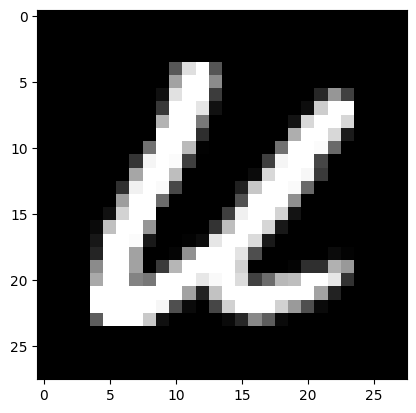

In [10]:
# Try un-trained network
img,lbl = train[torch.randint(len(train),size=(1,))]
plt.imshow(img.squeeze().cpu(),"grey")

prediction = Letter_classifier(img)[0]

print(alphabet_dictionary[lbl.cpu().item()])
print("Predicción: ",alphabet_dictionary[prediction.argmax().item()])

In [11]:
batch_size = 250

train_loader = torch.utils.data.DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)

val_loader = torch.utils.data.DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
    dataset=test,
    shuffle=True,
    batch_size=batch_size
)

In [12]:
# epochs = 30
# learning_rate = 0.01

epochs = 10
learning_rate = 0.1


loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Letter_classifier.parameters(), lr=learning_rate)

## Entrenamiento del modelo

Modificar para que devuelvan el loss y la precisión en cada paso.

In [13]:
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses = []
    train_accuracy = []

    for nlote,(x,y) in enumerate(loader):
        x,y = x.cuda(), y.cuda()[:,0]

        # Forward Pass
        logits = model(x)

        # Backpropagation
        loss = loss_fn(logits,y)    #Calculo de loss
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        # Guardamos algunas características para plotear al final
        train_losses += [loss.item()]
        train_accuracy += [(logits.argmax(1)==y).type(torch.float).sum().item()/ batch_size] 

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote: ",nlote)
            print("Loss: ",loss.item())

    train_losses_mean = sum(train_losses) / nlotes
    train_accuracy_mean = sum(train_accuracy) / nlotes
    
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {(100*train_accuracy_mean):>0.1f}% / {train_losses_mean:>8f}")

    return train_losses, train_accuracy

In [14]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, loss_fn:callable):
    
    val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses, val_accuracy = 0,0

    with torch.no_grad():       #Cancelo el calculo del gradiente
        for x,y in loader:
            
            x,y = x.cuda(), y.cuda()[:,0]

            logits = model(x)       # Inferencia
            
            val_losses += loss_fn(logits,y.long()).item()
            val_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

    val_losses /= nlotes
    val_accuracy /= val_size

    print(f"\t\tValidación: {(100*val_accuracy):>0.1f}% / {val_losses:>8f}")



In [15]:
loss_history = []
accuracy_history = []
for epoch in range(epochs):
    print(f"Itenración: {(epoch + 1)} / {epochs} -----------------------------")
    
    #Train
    epoch_loss,epoch_acc = train_loop(train_loader,Letter_classifier,optimizer,loss)

    loss_history += epoch_loss
    accuracy_history += epoch_acc


    #Validation
    val_loop(val_loader,Letter_classifier,loss)

print("Finalizado entrenamiento del modelo!")

Itenración: 1 / 10 -----------------------------
Nº de lote:  0
Loss:  3.2262299060821533
Nº de lote:  10
Loss:  3.20609188079834
Nº de lote:  20
Loss:  3.1660923957824707
Nº de lote:  30
Loss:  3.142092227935791
Nº de lote:  40
Loss:  3.210092306137085
Nº de lote:  50
Loss:  3.206092357635498
Nº de lote:  60
Loss:  3.154092311859131
Nº de lote:  70
Loss:  3.1900923252105713
Nº de lote:  80
Loss:  3.1580922603607178
Nº de lote:  90
Loss:  3.194092273712158
Nº de lote:  100
Loss:  3.206092357635498
Nº de lote:  110
Loss:  3.194092035293579
Nº de lote:  120
Loss:  3.2300922870635986
Nº de lote:  130
Loss:  3.1660923957824707
Nº de lote:  140
Loss:  3.1820921897888184
Nº de lote:  150
Loss:  3.1740922927856445
Nº de lote:  160
Loss:  3.2260921001434326
Nº de lote:  170
Loss:  3.1740922927856445
Nº de lote:  180
Loss:  3.1780922412872314
Nº de lote:  190
Loss:  3.206092357635498
Nº de lote:  200
Loss:  3.1900923252105713
Nº de lote:  210
Loss:  3.1900923252105713
Nº de lote:  220
Loss:  3.

Resultados:
* Tiempo de Entrenamiento: 40s.
* Precisión tras entrenamiento:43%


## Probamos el modelo de clasificación.

Text(0, 0.5, 'MSE')

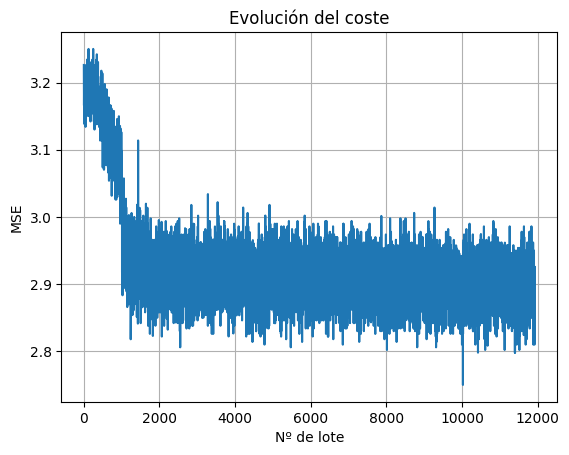

In [16]:
plt.plot(range(len(loss_history)),loss_history);
plt.grid();

axes = plt.axis()

# plt.axis((axes[0],axes[1],2.8,3.8))
plt.title("Evolución del coste")

plt.xlabel("Nº de lote")
plt.ylabel("MSE")

Text(0, 0.5, 'Precisión')

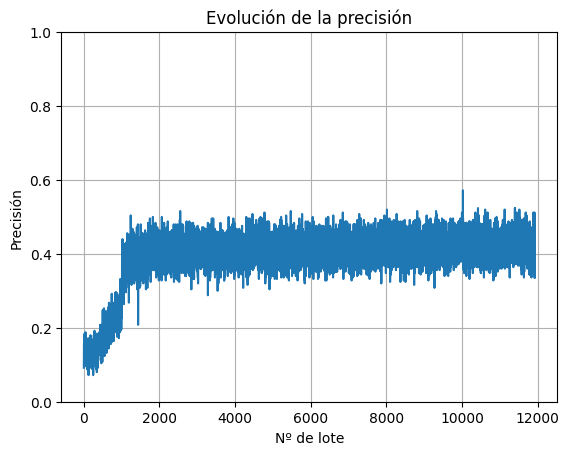

In [18]:
plt.plot(range(len(accuracy_history)),accuracy_history);
plt.grid();

axes = plt.axis()

plt.axis((axes[0],axes[1],0,1))
plt.title("Evolución de la precisión")

plt.xlabel("Nº de lote")
plt.ylabel("Precisión")

Categoría: P
Categoría predicha por la red: R


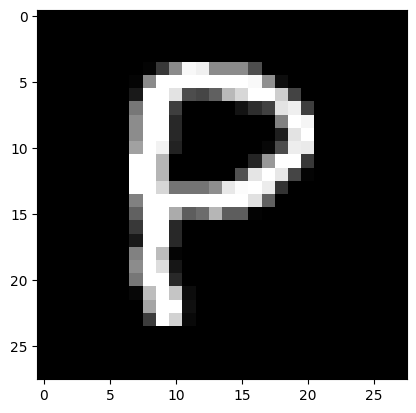

In [17]:
import random
img = test[random.randint(0,len(test))]

label = alphabet_dictionary[img[1].item()]
plt.imshow(img[0].squeeze().cpu(), "grey");
print(f"Categoría: {label}")

model_output = Letter_classifier(img[0])
model_label = alphabet_dictionary[model_output.argmax(1).item()]

print(f"Categoría predicha por la red: {model_label}")


In [19]:
val_loop(test_loader,Letter_classifier,loss)

		Validación: 42.8% / 2.894388
